# Grokking

In [1]:
# Available arguments
# parser.add_argument("--mod", choices=["all", "97", "113"], default="all")
# parser.add_argument("--epochs", type=int, default=10)
# parser.add_argument("--criterion", type=str, default="CrossEntropyLoss")

# # GPT config params
# parser.add_argument("--n_layer", type=int, default=12)
# parser.add_argument("--n_head", type=int, default=12)
# parser.add_argument("--n_embd", type=int, default=768)
# parser.add_argument("--dropout", type=float, default=0.0)
# parser.add_argument("--bias", type=bool, default=True)
# parser.add_argument("--batch_size", type=int, default=64)
# parser.add_argument("--block_size", type=int, default=16)
# parser.add_argument(
#     "--vocab_size", type=int, default=-1
# )  # -1 if using the vocab size from the dataset

# # Optimizer config
# parser.add_argument("--learning_rate", type=float, default=6e-4)
# parser.add_argument("--weight_decay", type=float, default=1e-1)
# parser.add_argument("--beta1", type=float, default=0.9)
# parser.add_argument("--beta2", type=float, default=0.95)

# parser.add_argument("--exp_name", type=str, default="mod_gpt")





import train
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Setup 
args = {
    'mod': '97',
    "math_op": "/",
    "epochs": "1",
    "n_layer": "2",
    "n_head": "4",
    "n_embd": "128",
    "block_size": "32",  # [x, y, =] or [x, y, z]
    "dropout": "0.0",
    "bias": "True",
    "learning_rate": "1e-3",
    "weight_decay": "1",
    "batch_size": "512",
    'exp_name': "grok",
    "eval_every": "1000",
    "num_steps": "1_000_000",
}
config = train.parse_args(train.build_arg_input(**args))
print("Config loaded. Using config")

train_loader, val_loader, test_loader = train.load_dataset(config)
print("Data loaded")
# print(json.dumps(vars(config), indent=4))


# Create the transformer
gpt, optimizer = train.gen_gpt(config)
print("GPT built")
# Train loop
print("Train started")
train_losses, train_acc, val_losses, val_acc = train.train_model(
    gpt, train_loader, val_loader, config, optimizer
)
print("Train done")

# Testing
train.test_model(gpt, test_loader, config)

# Save trained model,configs and losses
with open(config.exp_name + "_config.json", "w") as f:
    json.dump(vars(config), f, indent=4)

torch.save(gpt.state_dict(), config.exp_name + ".pth")

with open(config.exp_name + "_losses.json", "w") as f:
    json.dump({"train_losses": train_losses, "val_losses": val_losses}, f)

print(len(train_losses))
print(len(val_losses))
# df = pd.DataFrame({"train_losses": train_losses, "val_losses": val_losses})
# df.to_csv(f"{config.exp_name}_losses.csv", index=False)
# df.to_parquet(f"{config.exp_name}_losses.csv", index=False)

Config loaded. Using config
Filtering dataset for p=97
Filtering dataset for op=/
Train dataset size: 4743
Val dataset size: 2393
Test dataset size: 2370
Data loaded
Actual GPT config
GPTConfig(block_size=32, vocab_size=14, n_layer=1, n_head=2, n_embd=64, dropout=0.0, bias=True)
number of parameters: 0.05M
num decayed parameter tensors: 6, with 52,096 parameters
num non-decayed parameter tensors: 10, with 960 parameters
using fused AdamW: True
Using device: cuda:0
GPT built
Train started


Training:   1%|          | 8186/1000000 [02:06<4:15:38, 64.66it/s, acc=0.82, loss=0.502]  


KeyboardInterrupt: 

## Visualize Grokking

(1000000,)
(1000000,)


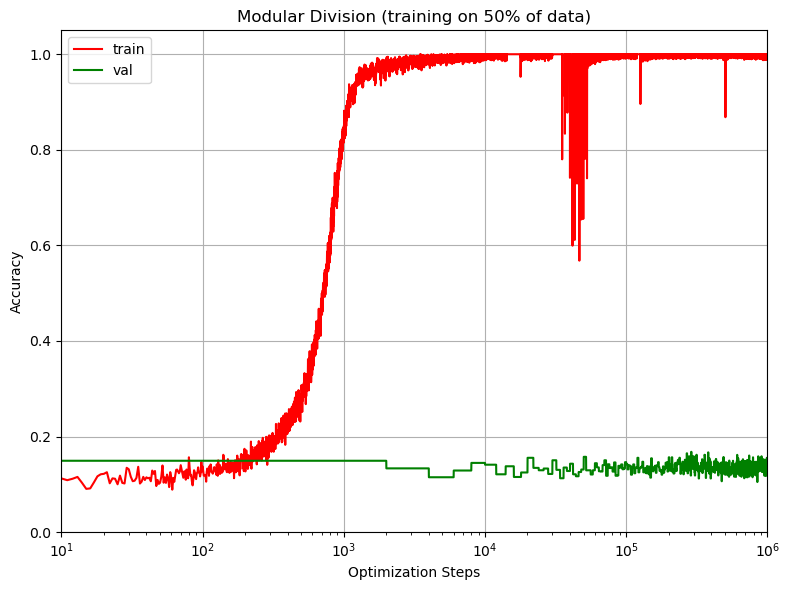

In [15]:
# np.load("grok_train_losses", train_losses[0])
train_acc = np.load("grok_train_acc.npy")
print(train_acc.shape)
# np.load("grok_val_losses", val_losses)
val_acc = np.repeat(np.load("grok_val_acc.npy"), 2000)
print(val_acc.shape)
steps = np.arange(1e6)
# Plot
plt.figure(figsize=(8, 6))
plt.plot(steps, train_acc, color='red', label='train')
# plt.plot(steps, train_acc, color='red', alpha=0.2)
plt.plot(steps, val_acc, color='green', label='val')
# plt.plot(steps, val_acc, color='green', alpha=0.2)

# Decorations
plt.xscale("log")
plt.xlabel("Optimization Steps")
plt.ylabel("Accuracy")
plt.title("Modular Division (training on 50% of data)")
plt.ylim([0, 1.05])
plt.xlim([10, 1e6])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()